# Transfer Learning para o dataset CUHK01

Modelo treinado com os datasets Market-1501 e CUHK03

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision import datasets as tv_datasets
from torch.autograd import Variable
from  torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.datasets as dset
import numpy as np
import cv2

from center_loss import CenterLoss
from frw import L2_penalty_with_constant
from reid_model import ReID_Net
from datasets import CUHK01
from custom_transforms import RandomTranslation
from evaluation import pairwise_squared_euclidian_distance, generate_query, \
                        get_topk_results, mapk, calculate_mAP
    
from utils import MetricAverager, save_checkpoint, load_checkpoint
import time
import shutil

## Dataset, transformações de data augmentation e DataLoaders

In [3]:
data_transforms = {
    'train': transforms.Compose([
        RandomTranslation(0.1),   # translação em numpy array
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),    # range [0.0, 1.0]
        transforms.Lambda(lambda t: t/0.5 - 1)    # range [-1.0, 1.0]
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda t: t/0.5 - 1)
    ])
}

In [6]:
datasets = {
    'train': CUHK01('../reid/datasets/cuhk01_train_correct.npz', train=True,
                    transform=data_transforms['train']),
    'valid': CUHK01('../reid/datasets/cuhk01_train_correct.npz', train=False,
                    transform=data_transforms['valid'])
}

batch_size = 128
dset_loaders = {
    'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'valid': DataLoader(datasets['valid'], batch_size=batch_size, shuffle=False, num_workers=4)
}

In [7]:
print('CUHK01:')
print('Treinamento:')
print('X:', datasets['train'].X.shape, datasets['train'].X.dtype, datasets['train'].X.min(), datasets['train'].X.max())
print('y:', datasets['train'].y.shape, datasets['train'].y.dtype, datasets['train'].y.min(), datasets['train'].y.max())
print('Validação:')
print('X:', datasets['valid'].X.shape, datasets['valid'].X.dtype, datasets['valid'].X.min(), datasets['valid'].X.max())
print('y:', datasets['valid'].y.shape, datasets['valid'].y.dtype, datasets['valid'].y.min(), datasets['valid'].y.max())

CUHK01:
Treinamento:
X: (1540, 128, 48, 3) uint8 0 255
y: (1540,) int64 0 384
Validação:
X: (400, 128, 48, 3) uint8 0 255
y: (400,) int64 0 99


In [8]:
print(len(dset_loaders['train']), len(dset_loaders['valid']))

13 4


# Carregando o modelo para Transfer Learning

O modelo carregado tem a última camada `classifier` e o buffer `centers` com dimensões incorretas para o uso no treinamento do VIPeR.

In [9]:
model_to_transfer = 'market1501_and_cuhk03_map_epoch_136.pth'
ckpt = torch.load(model_to_transfer)

In [10]:
num_centers = ckpt['state_dict']['centers'].size(0)
print(num_centers)

1918


In [11]:
num_classes = len(np.unique(datasets['train'].y))
print('Novo número de classes: ', num_classes)

Novo número de classes:  385


In [28]:
model = ReID_Net(num_centers)
model.load_state_dict(ckpt['state_dict'])
model.prepare_model_to_transfer(num_classes)

In [29]:
print('Novas dimensões dos centros: {}'.format(model.centers.size()))
print('Nova camada final: ', model.classifier)

Novas dimensões dos centros: torch.Size([385, 512])
Nova camada final:  Linear (512 -> 385)


## Função de treinamento

In [18]:
def train_epoch(model, optimizer, epoch, criterions, train_loader, val_loader, use_cuda,
                lambda_cl, beta_frw, query_splits, cuda_device=None):
    print("Training... Epoch = %d" % epoch)

    train_accum = 0
    n_train_samples = 0
    val_accum = 0
    n_val_samples = 0
    
    tlosses = {
        'center_loss': MetricAverager(),
        'softmax_loss': MetricAverager(),
        'total': MetricAverager(),
    }
    
    #train
    model.train(True)
    t0 = time.time()
    for i,(data, target) in enumerate(train_loader):
        
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        data, target = Variable(data), Variable(target)
        
        features, pred = model(data)
        
        # Softmax loss + center loss
        softmax_loss = criterions[0](pred, target)
        center_loss = lambda_cl * criterions[1](features, target)
        loss = softmax_loss + center_loss
        
        # Acrescenta a penalização L2 na camada FRW
        for (name, p) in model.named_parameters():
            if name == 'frw.weight' or name == 'fc_embeddings.3.weight':
                loss += beta_frw * criterions[2](p)
        
        _, preds = torch.max(pred.data, 1)
        correct = (preds == target.data).sum()
        train_accum += correct
        n_train_samples += target.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        tlosses['center_loss'].update(center_loss.data.cpu().numpy()[0])
        tlosses['softmax_loss'].update(softmax_loss.data.cpu().numpy()[0])
        tlosses['total'].update(loss.data.cpu().numpy()[0])
        
        t1 = time.time() - t0
        train_string = 'Epoch {}, Batch {}/{} ({:.1f}s): Center loss {:.4f}, Softmax loss {:.4f}, ' \
            'total {:.4f}'.format(epoch, i+1, len(train_loader), t1, tlosses['center_loss'], 
                                  tlosses['softmax_loss'], tlosses['total'])
        print(train_string, end='\r' if i < len(train_loader)-1 else '\n')
    
    train_acc = train_accum / n_train_samples
    print('Train accuracy: {:.2%}'.format(train_acc))
        
    # Validation: in the validation phase, we extract the features of all the validation images.
    # Then, we calculate the pairwise euclidian distance for all samples and calculate
    # the Mean Average Precision for the rankings in a Cross-camera search configuration: the query and
    # gallery sets have images from different camera views and, for each person identity, one image 
    # is randomly selected for each set. This is done for N query/gallery split configurations.
    
    t0 = time.time()
    model.train(False)
    
    val_feats = []
    val_pids = []
    
    valid_metrics = {
        'map': MetricAverager(),
    }
    
    for i, (data, target) in enumerate(val_loader):
        
        if use_cuda:
            data = data.cuda()
        data = Variable(data, volatile=True)

        features, pred = model(data)
        val_feats.append(features.data.cpu())
        
    val_feats = torch.cat(val_feats)
    
    # Calculates mAP for the validation set, as a Query-Gallery set
    val_dataset = val_loader.dataset
    val_cam_ids = val_dataset.cam_ids
    y_val = val_dataset.y
    
    # Gallery: may or may not include distractors
    y_gallery = y_val
    gal_cam_ids = val_cam_ids
    
    for i, query_indices_by_cam in enumerate(query_splits):
        #query_indices_by_cam = generate_query(y_val, val_cam_ids)
        val_map = calculate_mAP(query_indices_by_cam, val_feats, y_gallery, gal_cam_ids)
        valid_metrics['map'].update(val_map)

        t1 = time.time() - t0
        print('Validation mAP (split {:>2}/{}) ({:.1f}s): {:.2%}'.format(i+1, len(query_splits),
                t1, valid_metrics['map'].mean), end='\r' if i+1 < len(query_splits) else '\n')
        
    print('-'*80)
    
    metrics = {
        'train': {
            'losses': {
                'center_loss': tlosses['center_loss'].mean,
                'softmax_loss': tlosses['softmax_loss'].mean,
                'total': tlosses['total'].mean,
            },
            'accuracy': train_acc,
        },
        'valid': {
            'map': valid_metrics['map'].mean
        }
    }
    
    return metrics

## Função geral

In [19]:
def train(epochs, model=None, resume=None, checkpoint_fn=None, **train_args):
    best_val_loss = None
    last_epoch = 0
    
    train_history = []
    
    use_cuda = train_args.get('use_cuda')
    num_classes = train_args.pop('num_classes', None)
    
    if model is None:
        if num_classes is None:
            raise ValueError('Deve-se informar o número de classes {`num_classes`}')
        model = ReID_Net(num_classes)
    
    if resume is not None:
        scheduler, last_epoch, best_val_loss, train_history = load_checkpoint(resume, model, optimizer4nn)
        num_classes = model.centers.size(0)
    
    # NLLLoss
    nllloss = nn.NLLLoss() #CrossEntropyLoss = log_softmax + NLLLoss
    # CenterLoss
    loss_weight = 1.0

    # FRW L2 penalty
    frw_l2_penalty = L2_penalty_with_constant(200)
    
    if use_cuda:
        nllloss = nllloss.cuda()
        model = model.cuda()
        frw_l2_penalty = frw_l2_penalty.cuda()
        
    
    alpha = train_args.pop('alpha')

    centerloss = CenterLoss(model, model.centers, num_classes, alpha)
    criterions = [nllloss, centerloss, frw_l2_penalty]

    # optimzer4nn
    lr = train_args.pop('lr')
    weight_decay = train_args.pop('weight_decay')
    optimizer4nn = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                                     lr=lr, weight_decay=weight_decay)
    
    # LR Scheduler
    scheduler_patience = train_args.pop('scheduler_patience', 35)
    scheduler_factor = train_args.pop('scheduler_factor', 0.1)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer4nn, mode='max',
                                               patience=scheduler_patience, 
                                               factor=scheduler_factor, verbose=True)
        
    max_val_map = best_val_loss or -np.Inf
    
    patience = train_args.pop('patience', 50)
    no_improve = 0
    
    print('train_args:', train_args, '\n')
    
    # Gera os splits de query e gallery que serão usados nas métricas de validação
    val_dataset = train_args['val_loader'].dataset
    query_splits = []
    for i in range(5):
        query_splits.append(generate_query(val_dataset.y, val_dataset.cam_ids))
    
    for epoch in range(last_epoch+1, epochs):

        metrics = train_epoch(model, optimizer4nn, epoch, criterions,
                              query_splits=query_splits, **train_args)
        
        scheduler.step(metrics['valid']['map'])
        train_history.append(metrics)
        
        # Save checkpoint and EarlyStop
        if metrics['valid']['map'] > max_val_map:
            print("Max. Valid. mAP / Epoch's Valid. mAP: {:.2%} | {:.2%}".format(
                max_val_map, metrics['valid']['map']))
            print('Salvando melhor modelo...')
            max_val_map = metrics['valid']['map']
            state = {
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'best_val_loss': max_val_map,
                'train_softmax_loss': metrics['train']['losses']['softmax_loss'],
                'history': train_history,
            }
            opts = {'is_best': False}
            if checkpoint_fn is not None:
                opts.update({'filename': checkpoint_fn.format(epoch+1)})
            save_checkpoint(state, **opts)
            no_improve = 0
            print('-'*80)
        else:
            no_improve += 1
            if no_improve > patience:
                print('Early stopping at epoch {}.'.format(epoch))
                break
                
    return model, train_history

# Primeira etapa: treinamento somente da última camada

Congela todos os parâmetros, exceto os da última camada

In [30]:
# len(model.parameters) == 53
for i, p in enumerate(model.parameters()):
    if i not in (51, 52):
        p.requires_grad = False

# Verifica que há apenas 2 parâmetros com requires_grad == True
for p in filter(lambda x: x.requires_grad, model.parameters()):
    print(p.size())

torch.Size([385, 512])
torch.Size([385])


### Parâmetros de treinamento

In [23]:
epochs = 500

train_params = {
    'lr': 0.005,
    'weight_decay': 0.001,
    'lambda_cl': 0.01,
    'alpha': 0.5,
    'num_classes': len(np.unique(datasets['train'].y)),
    'train_loader': dset_loaders['train'],
    'val_loader': dset_loaders['valid'],
    'use_cuda': True,
    'beta_frw': 0.0001,
    'cuda_device': None,
    'patience': 50,
    'scheduler_patience': 30,
    'scheduler_factor': 0.1
}

In [31]:
try:
    model, train_history = train(epochs, model=model, 
                                 checkpoint_fn='transfer_cuhk01_classifier_{}.pth', 
                                 **train_params)
    
except KeyboardInterrupt:
    print('Interrompendo...')

train_args: {'cuda_device': None, 'val_loader': <torch.utils.data.dataloader.DataLoader object at 0x7f27f410f0f0>, 'beta_frw': 0.0001, 'lambda_cl': 0.01, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7f27f410fba8>, 'use_cuda': True} 

Training... Epoch = 1
Epoch 1, Batch 13/13 (0.9s): Center loss 3.0782, Softmax loss 5.2549, total 8.3356
Train accuracy: 11.10%
Validation mAP (split  5/5) (0.4s): 51.81%
--------------------------------------------------------------------------------
Max. Valid. mAP / Epoch's Valid. mAP: -inf% | 51.81%
Salvando melhor modelo...
--------------------------------------------------------------------------------
Training... Epoch = 2
Epoch 2, Batch 13/13 (0.9s): Center loss 1.2105, Softmax loss 1.9976, total 3.2105
Train accuracy: 71.95%
Validation mAP (split  5/5) (0.4s): 51.28%
--------------------------------------------------------------------------------
Training... Epoch = 3
Epoch 3, Batch 13/13 (0.9s): Center loss 1.0096, Softmax 

Epoch 32, Batch 13/13 (1.0s): Center loss 0.9666, Softmax loss 0.2822, total 1.2513
Train accuracy: 96.82%
Validation mAP (split  5/5) (0.4s): 51.15%
--------------------------------------------------------------------------------
Epoch    31: reducing learning rate of group 0 to 5.0000e-04.
Training... Epoch = 33
Epoch 33, Batch 13/13 (0.9s): Center loss 0.9823, Softmax loss 0.2224, total 1.2072
Train accuracy: 97.92%
Validation mAP (split  5/5) (0.4s): 50.68%
--------------------------------------------------------------------------------
Training... Epoch = 34
Epoch 34, Batch 13/13 (0.9s): Center loss 0.9523, Softmax loss 0.1809, total 1.1357
Train accuracy: 98.05%
Validation mAP (split  5/5) (0.4s): 50.99%
--------------------------------------------------------------------------------
Training... Epoch = 35
Epoch 35, Batch 13/13 (0.9s): Center loss 0.9531, Softmax loss 0.2261, total 1.1816
Train accuracy: 98.51%
Validation mAP (split  5/5) (0.4s): 51.69%
--------------------------

Validation mAP (split  5/5) (0.4s): 50.45%
--------------------------------------------------------------------------------
Training... Epoch = 64
Epoch 64, Batch 13/13 (0.9s): Center loss 0.9597, Softmax loss 0.1539, total 1.1161
Train accuracy: 99.55%
Validation mAP (split  5/5) (0.4s): 50.94%
--------------------------------------------------------------------------------
Training... Epoch = 65
Epoch 65, Batch 13/13 (1.0s): Center loss 0.9749, Softmax loss 0.2711, total 1.2485
Train accuracy: 99.68%
Validation mAP (split  5/5) (0.4s): 51.27%
--------------------------------------------------------------------------------
Training... Epoch = 66
Epoch 66, Batch 13/13 (0.9s): Center loss 0.9703, Softmax loss 0.2231, total 1.1959
Train accuracy: 99.68%
Validation mAP (split  5/5) (0.4s): 50.80%
--------------------------------------------------------------------------------
Training... Epoch = 67
Epoch 67, Batch 13/13 (0.9s): Center loss 0.9504, Softmax loss 0.1603, total 1.1131
Train a

Epoch 95, Batch 13/13 (0.9s): Center loss 0.9769, Softmax loss 0.1743, total 1.1536
Train accuracy: 99.68%
Validation mAP (split  5/5) (0.4s): 51.04%
--------------------------------------------------------------------------------
Training... Epoch = 96
Epoch 96, Batch 13/13 (0.9s): Center loss 0.9619, Softmax loss 0.1410, total 1.1054
Train accuracy: 99.74%
Validation mAP (split  5/5) (0.4s): 51.66%
--------------------------------------------------------------------------------
Training... Epoch = 97
Epoch 97, Batch 13/13 (0.9s): Center loss 0.9591, Softmax loss 0.2386, total 1.2001
Train accuracy: 99.74%
Validation mAP (split  5/5) (0.4s): 50.92%
--------------------------------------------------------------------------------
Training... Epoch = 98
Epoch 98, Batch 13/13 (0.9s): Center loss 0.9996, Softmax loss 0.3057, total 1.3078
Train accuracy: 99.74%
Validation mAP (split  5/5) (0.4s): 50.95%
--------------------------------------------------------------------------------
Trainin

Epoch 127, Batch 13/13 (1.0s): Center loss 0.9444, Softmax loss 0.1519, total 1.0987
Train accuracy: 99.74%
Validation mAP (split  5/5) (0.4s): 50.85%
--------------------------------------------------------------------------------
Training... Epoch = 128
Epoch 128, Batch 13/13 (0.9s): Center loss 0.9765, Softmax loss 0.2494, total 1.2284
Train accuracy: 99.94%
Validation mAP (split  5/5) (0.4s): 50.37%
--------------------------------------------------------------------------------
Training... Epoch = 129
Epoch 129, Batch 13/13 (0.9s): Center loss 0.9562, Softmax loss 0.2042, total 1.1628
Train accuracy: 99.68%
Validation mAP (split  5/5) (0.4s): 50.43%
--------------------------------------------------------------------------------
Training... Epoch = 130
Epoch 130, Batch 13/13 (1.0s): Center loss 0.9958, Softmax loss 0.2240, total 1.2222
Train accuracy: 99.68%
Validation mAP (split  5/5) (0.3s): 50.75%
--------------------------------------------------------------------------------


## Gráficos do treinamento

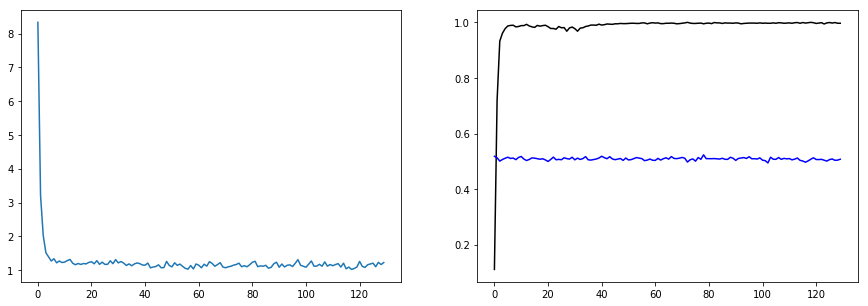

In [43]:
metrics = {
    'train_total_loss': [l['train']['losses']['total'] for l in train_history],
    'train_accuracy': [l['train']['accuracy'] for l in train_history],
    'valid_map': [l['valid']['map'] for l in train_history],
}

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(metrics['train_total_loss'])
plt.subplot(122)
plt.plot(metrics['train_accuracy'], c='k')
plt.plot(metrics['valid_map'], c='b')

# Segunda etapa: fine-tuning da rede completa


## Carrega o melhor modelo da etapa 1

In [45]:
ckpt = torch.load('transfer_cuhk01_classifier_80.pth')
model.load_state_dict(ckpt['state_dict'])

In [46]:
# len(model.parameters) == 53
for i, p in enumerate(model.parameters()):
    p.requires_grad = True

# Verifica que há apenas 2 parâmetros com requires_grad == True
print('Número de camadas que serão otimizadas:', len(list(filter(lambda x: x.requires_grad, model.parameters()))))

Número de camadas que serão otimizadas: 53


### Parâmetros de treinamento

In [47]:
epochs = 500

train_params = {
    'lr': 0.0001,
    'weight_decay': 0.001,
    'lambda_cl': 0.01,
    'alpha': 0.5,
    'num_classes': len(np.unique(datasets['train'].y)),
    'train_loader': dset_loaders['train'],
    'val_loader': dset_loaders['valid'],
    'use_cuda': True,
    'beta_frw': 0.0001,
    'cuda_device': None,
    'patience': 50,
    'scheduler_patience': 20,
    'scheduler_factor': 0.1
}

In [48]:
try:
    model, train_history = train(epochs, model=model, 
                                 checkpoint_fn='transfer_cuhk01_finetuning_{}.pth', 
                                 **train_params)

except KeyboardInterrupt:
    print('Interrompendo...')

train_args: {'cuda_device': None, 'val_loader': <torch.utils.data.dataloader.DataLoader object at 0x7f27f410f0f0>, 'beta_frw': 0.0001, 'lambda_cl': 0.01, 'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7f27f410fba8>, 'use_cuda': True} 

Training... Epoch = 1
Epoch 1, Batch 13/13 (2.9s): Center loss 0.8753, Softmax loss 0.1852, total 1.0631
Train accuracy: 99.61%
Validation mAP (split  5/5) (0.4s): 65.64%
--------------------------------------------------------------------------------
Max. Valid. mAP / Epoch's Valid. mAP: -inf% | 65.64%
Salvando melhor modelo...
--------------------------------------------------------------------------------
Training... Epoch = 2
Epoch 2, Batch 13/13 (2.9s): Center loss 0.7557, Softmax loss 0.2919, total 1.0504
Train accuracy: 99.61%
Validation mAP (split  5/5) (0.4s): 64.69%
--------------------------------------------------------------------------------
Training... Epoch = 3
Epoch 3, Batch 13/13 (2.9s): Center loss 0.6931, Softmax 

Epoch 23, Batch 13/13 (3.0s): Center loss 0.4788, Softmax loss 0.1319, total 0.6135
Train accuracy: 99.94%
Validation mAP (split  5/5) (0.4s): 73.87%
--------------------------------------------------------------------------------
Training... Epoch = 24
Epoch 24, Batch 13/13 (3.0s): Center loss 0.4863, Softmax loss 0.1925, total 0.6815
Train accuracy: 99.81%
Validation mAP (split  5/5) (0.4s): 75.59%
--------------------------------------------------------------------------------
Training... Epoch = 25
Epoch 25, Batch 13/13 (2.9s): Center loss 0.4668, Softmax loss 0.1350, total 0.6046
Train accuracy: 100.00%
Validation mAP (split  5/5) (0.5s): 76.99%
--------------------------------------------------------------------------------
Max. Valid. mAP / Epoch's Valid. mAP: 76.62% | 76.99%
Salvando melhor modelo...
--------------------------------------------------------------------------------
Training... Epoch = 26
Epoch 26, Batch 13/13 (3.1s): Center loss 0.4801, Softmax loss 0.1891, total

Epoch 50, Batch 13/13 (2.9s): Center loss 0.4136, Softmax loss 0.1633, total 0.5794
Train accuracy: 100.00%
Validation mAP (split  5/5) (0.4s): 78.99%
--------------------------------------------------------------------------------
Training... Epoch = 51
Epoch 51, Batch 13/13 (2.9s): Center loss 0.4182, Softmax loss 0.1647, total 0.5855
Train accuracy: 99.87%
Validation mAP (split  5/5) (0.4s): 79.94%
--------------------------------------------------------------------------------
Max. Valid. mAP / Epoch's Valid. mAP: 79.52% | 79.94%
Salvando melhor modelo...
--------------------------------------------------------------------------------
Training... Epoch = 52
Epoch 52, Batch 13/13 (2.9s): Center loss 0.3877, Softmax loss 0.1397, total 0.5300
Train accuracy: 99.94%
Validation mAP (split  5/5) (0.4s): 79.09%
--------------------------------------------------------------------------------
Training... Epoch = 53
Epoch 53, Batch 13/13 (2.9s): Center loss 0.4032, Softmax loss 0.1630, total

Epoch 79, Batch 13/13 (2.8s): Center loss 0.3627, Softmax loss 0.1580, total 0.5232
Train accuracy: 99.94%
Validation mAP (split  5/5) (0.5s): 80.84%
--------------------------------------------------------------------------------
Training... Epoch = 80
Epoch 80, Batch 13/13 (2.8s): Center loss 0.3571, Softmax loss 0.1595, total 0.5192
Train accuracy: 99.94%
Validation mAP (split  5/5) (0.5s): 79.90%
--------------------------------------------------------------------------------
Training... Epoch = 81
Epoch 81, Batch 13/13 (2.8s): Center loss 0.3672, Softmax loss 0.1133, total 0.4831
Train accuracy: 99.94%
Validation mAP (split  5/5) (0.4s): 80.43%
--------------------------------------------------------------------------------
Training... Epoch = 82
Epoch 82, Batch 13/13 (2.9s): Center loss 0.3741, Softmax loss 0.1852, total 0.5618
Train accuracy: 99.87%
Validation mAP (split  5/5) (0.5s): 79.95%
--------------------------------------------------------------------------------
Trainin

Epoch 111, Batch 13/13 (3.0s): Center loss 0.3472, Softmax loss 0.1297, total 0.4795
Train accuracy: 100.00%
Validation mAP (split  5/5) (0.4s): 80.09%
--------------------------------------------------------------------------------
Training... Epoch = 112
Epoch 112, Batch 13/13 (2.9s): Center loss 0.3532, Softmax loss 0.2213, total 0.5771
Train accuracy: 99.87%
Validation mAP (split  5/5) (0.4s): 81.11%
--------------------------------------------------------------------------------
Epoch   111: reducing learning rate of group 0 to 1.0000e-05.
Training... Epoch = 113
Epoch 113, Batch 13/13 (2.9s): Center loss 0.3271, Softmax loss 0.1515, total 0.4812
Train accuracy: 99.94%
Validation mAP (split  5/5) (0.4s): 81.40%
--------------------------------------------------------------------------------
Training... Epoch = 114
Epoch 114, Batch 13/13 (2.9s): Center loss 0.3583, Softmax loss 0.1711, total 0.5320
Train accuracy: 99.87%
Validation mAP (split  5/5) (0.4s): 81.58%
------------------

Epoch 172, Batch 13/13 (2.9s): Center loss 0.3290, Softmax loss 0.1347, total 0.4662
Train accuracy: 99.87%
Validation mAP (split  5/5) (0.4s): 81.77%
--------------------------------------------------------------------------------
Training... Epoch = 173
Epoch 173, Batch 13/13 (2.8s): Center loss 0.3682, Softmax loss 0.1509, total 0.5216
Train accuracy: 99.94%
Validation mAP (split  5/5) (0.4s): 81.84%
--------------------------------------------------------------------------------
Training... Epoch = 174
Epoch 174, Batch 13/13 (2.9s): Center loss 0.3517, Softmax loss 0.1641, total 0.5184
Train accuracy: 99.94%
Validation mAP (split  5/5) (0.4s): 81.66%
--------------------------------------------------------------------------------
Training... Epoch = 175
Epoch 175, Batch 13/13 (2.8s): Center loss 0.3274, Softmax loss 0.1123, total 0.4422
Train accuracy: 99.94%
Validation mAP (split  5/5) (0.4s): 81.80%
--------------------------------------------------------------------------------


Epoch 235, Batch 13/13 (3.0s): Center loss 0.3357, Softmax loss 0.1133, total 0.4515
Train accuracy: 100.00%
Validation mAP (split  5/5) (0.4s): 81.89%
--------------------------------------------------------------------------------
Training... Epoch = 236
Epoch 236, Batch 13/13 (2.8s): Center loss 0.3279, Softmax loss 0.1426, total 0.4731
Train accuracy: 99.94%
Validation mAP (split  5/5) (0.4s): 81.76%
--------------------------------------------------------------------------------
Training... Epoch = 237
Epoch 237, Batch 13/13 (2.9s): Center loss 0.3175, Softmax loss 0.1051, total 0.4251
Train accuracy: 100.00%
Validation mAP (split  5/5) (0.4s): 81.81%
--------------------------------------------------------------------------------
Training... Epoch = 238
Epoch 238, Batch 13/13 (3.0s): Center loss 0.3265, Softmax loss 0.1110, total 0.4399
Train accuracy: 100.00%
Validation mAP (split  5/5) (0.4s): 82.03%
------------------------------------------------------------------------------